# Se importan las bibliotecas necesarias

In [37]:
import pandas as pd
import re
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
import lightgbm as lgb
from catboost import CatBoostRegressor
%matplotlib inline

# Se lee el .csv

In [2]:
train = pd.read_csv('csv/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Elaboración del modelo

Para este modelo se utilizará XGBoost para realizar las predicciones y se tendrán en cuenta los siguientes features extraídos del análisis exploratorio, los cuales fueron seleccionados por el grupo como aquellos que podrían resultan más interesantes:

- Palabras con mayor y menor porcentaje de veracidad.
- Pares de 2 palabras con mayor y menor porcentaje de veracidad.
- Tweets que contienen @, ¿?, ¡! tienden a ser falsos.
- Keywords con mayor y menor porcentaje de veracidad.
- Locaciones más y menos veraces.
- Longitud.

### Preparación del set de datos

#### Parte inicial

In [4]:
#Palabras con mayor y menor porcentaje de veracidad
min_repetitions = ((0.2/100)*len(train.index))
words = train['text'].str.split()
clean_words = []

for sentence in words:
    clean_sentence = []
    for word in sentence:
        clean_word = re.sub('[^A-Za-z0-9]+','', word)
        clean_sentence.append(clean_word.lower())
    clean_words.append(clean_sentence)

In [5]:
train_aux = train
train_aux['words'] = clean_words
train_aux = train_aux.explode('words')
train_aux.head()

,id,keyword,location,text,target,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,reason


In [6]:
train_aux = train_aux.groupby('words').agg({'target':['sum','count']})
train_aux = train_aux[train_aux['target']['count']>min_repetitions]
train_aux['veracity'] = train_aux['target']['sum']/train_aux['target']['count']
train_aux.head()

target        veracity
         sum count          
words                       
         904  2150  0.420465
05        14    18  0.777778
1         29    64  0.453125
10         9    23  0.391304
100        6    17  0.352941

In [7]:
train_aux.reset_index(inplace=True) 

In [8]:
#Pares de 2 palabras con mayor y menor porcentaje de veracidad.
train_aux2 = train
train_aux2['words'] = clean_words
words_pairs = []

for sentence in train_aux2['words']:
    pairs = []
    for i in range(len(sentence)-1):
        pairs.append(sentence[i] + ' ' + sentence[i+1])
    words_pairs.append(pairs)
    
train_aux2['words'] = words_pairs
train_aux2 = train_aux2.explode('words')
train_aux2.head()

,id,keyword,location,text,target,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,are the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,the reason
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,reason of


In [9]:
train_aux2 = train_aux2.groupby('words').agg({'target':['sum','count']})
train_aux2 = train_aux2[train_aux2['target']['count']>min_repetitions]
train_aux2['veracity'] = train_aux2['target']['sum']/train_aux2['target']['count']

In [10]:
#las palabras que son '' la cagan
train_aux2.head(10)

target        veracity
                 sum count          
words                               
                  66   118  0.559322
 abc              19    19  1.000000
 full              6    67  0.089552
 i                 6    19  0.315789
 the              32    57  0.561404
11yearold boy     20    20  1.000000
16yr old          28    28  1.000000
40 families       26    26  1.000000
70 years          30    31  0.967742
a blast            3    16  0.187500

In [11]:
train_aux2.reset_index(inplace=True)

In [12]:
# Keywords más y menos veraces
train_aux3 = train
train_aux3 = train_aux3.groupby('keyword').agg({'target':['sum','count']})
train_aux3 = train_aux3[train_aux3['target']['count']>min_repetitions]
train_aux3['veracity'] = train_aux3['target']['sum']/train_aux3['target']['count']
train_aux3.head()

target        veracity
                       sum count          
keyword                                   
ablaze                  13    36  0.361111
accident                24    35  0.685714
aftershock               0    34  0.000000
airplane%20accident     30    35  0.857143
ambulance               20    38  0.526316

In [13]:
train_aux3.reset_index(inplace=True)

In [14]:
# Locaciones más y menos veraces
train_aux4 = train
train_aux4 = train_aux4.groupby('location').agg({'target':['sum','count']})
train_aux4 = train_aux4[train_aux4['target']['count']>min_repetitions]
train_aux4['veracity'] = train_aux4['target']['sum']/train_aux4['target']['count']
train_aux4.head()

target        veracity
               sum count          
location                          
Australia        9    18  0.500000
California       7    17  0.411765
Canada          13    29  0.448276
Chicago, IL      9    18  0.500000
India           20    24  0.833333

In [15]:
train_aux4.reset_index(inplace=True)

#### Parte final

In [16]:
top_words = train_aux[train_aux['veracity']>0.9]['words']
worst_words = train_aux[train_aux['veracity']<0.1]['words']

In [17]:
top_words_pairs = train_aux2[train_aux2['veracity']>0.9]['words']
worst_words_pairs = train_aux2[train_aux2['veracity']<0.1]['words']

In [18]:
top_keywords = train_aux3[train_aux3['veracity']>0.9]['keyword']
worst_keywords = train_aux3[train_aux3['veracity']<0.1]['keyword']

In [19]:
top_locations = train_aux4[train_aux4['veracity']>0.9]['location']
worst_locations = train_aux4[train_aux4['veracity']<0.1]['location']

In [20]:
train = train.drop(columns='words')
train['long(char)'] = train['text'].str.len()

aux = []
for i in words:
    aux.append(len(i))

train['long(word)'] = aux
train.head()

,id,keyword,location,text,target,long(char),long(word)
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


In [21]:
def count_text_ocurrences(texts, words):
    ocurrences = []
    for text in texts:
        count = 0
        for word in words:
            if word in text:
                count = count+1
        ocurrences.append(count)
    return ocurrences

def count_ocurrences(searched, series):
    ocurrences = []
    for element in searched:
        count = 0
        if element in series:
            count = count+1
        ocurrences.append(count)
    return ocurrences

def contains_char(texts, char1, char2=''):
    ocurrences = []
    for text in texts:
        count = 0
        if char1 in text:
            count = 1
        if (count==0)&(char2!=''):
            if char2 in text:
                count = 1
        ocurrences.append(count)
    return ocurrences

In [22]:
train['top_words'] = count_text_ocurrences(train['text'], top_words)
train['worst_words'] = count_text_ocurrences(train['text'], worst_words)
train['top_words_pairs'] = count_text_ocurrences(train['text'], top_words_pairs)
train['worst_words_pairs'] = count_text_ocurrences(train['text'], worst_words_pairs)
train.head()

,id,keyword,location,text,target,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,1,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,1,0,0,0


In [23]:
train['top_keywords'] = count_ocurrences(train['keyword'], top_keywords)
train['worst_keywords'] = count_ocurrences(train['keyword'], worst_keywords)
train['top_locations'] = count_ocurrences(train['location'], top_locations)
train['worst_locations'] = count_ocurrences(train['location'], worst_locations)
train.head()

,id,keyword,location,text,target,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,1,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,1,0,0,0,0,0,0,0


In [24]:
train['@'] = contains_char(train['text'],'@')
train['¿,?'] = contains_char(train['text'],'\?', '¿')
train['!,¡'] = contains_char(train['text'],'!','¡')
train.head()

,id,keyword,location,text,target,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,@,"¿,?","!,¡"
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,0,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,1,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,1,0,0,0,0,0,0,0,0,0,0


In [25]:
train = train.drop(columns=['keyword','location','text'])
train = train.set_index('id')
train.head(20)

,target,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,@,"¿,?","!,¡"
id,,,,,,,,,,,,,,
1,1,69,13,0,0,0,0,0,0,0,0,0,0,0
4,1,38,7,0,0,0,0,0,0,0,0,0,0,0
5,1,133,22,1,0,0,0,0,0,0,0,0,0,0
6,1,65,8,1,0,0,0,0,0,0,0,0,0,0
7,1,88,16,1,0,0,0,0,0,0,0,0,0,0
8,1,110,18,1,0,0,0,0,0,0,0,0,0,0
10,1,95,14,0,0,0,0,0,0,0,0,0,0,0
13,1,59,15,0,0,1,0,0,0,0,0,0,0,0
14,1,79,12,0,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del set de datos

In [26]:
X, y = train.iloc[:,1:-1], train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=73)

#### XGBoost

In [27]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 80)

In [28]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
preds = xg_reg.predict(X_test)

In [30]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.6821366024518388
Precision Score : 0.6821917808219178
Recall Score : 0.5020161290322581
F1 Score : 0.5783972125435541


In [31]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.2, 0.3, 0.4],
#         'max_depth': [10, 15, 20]
#         }
# grid_acc = GridSearchCV(xg_reg, param_grid = params)
# grid_acc.fit(X_train, y_train)
# y_pred_acc = grid_acc.predict(X_test)

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc.round())))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc.round())))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc.round())))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc.round())))

#### RandomForest

In [32]:
rf_model = RandomForestRegressor(random_state=13, n_estimators=80, max_depth=20)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.6672504378283712
Precision Score : 0.6193415637860082
Recall Score : 0.6068548387096774
F1 Score : 0.6130346232179226


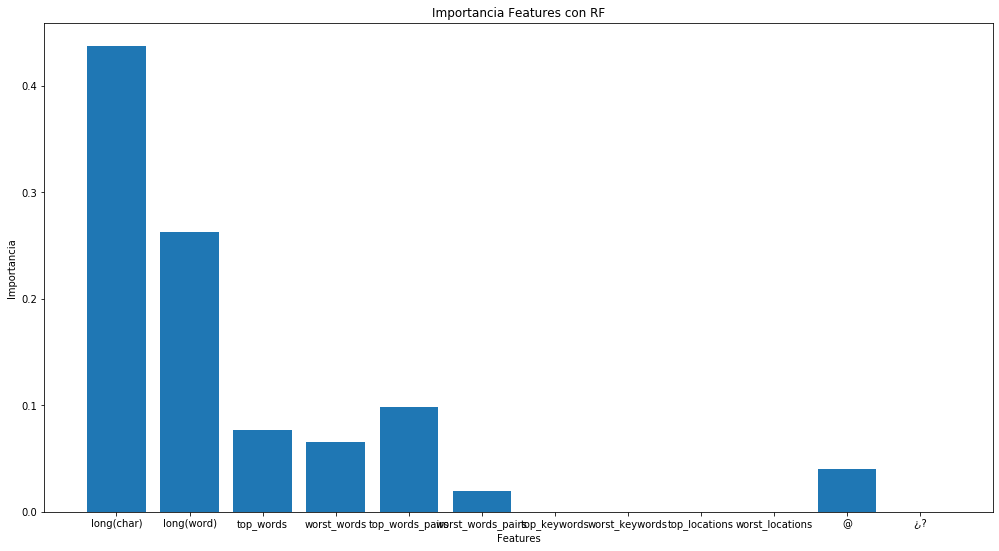

In [33]:
rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

#### LightGBM

In [35]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
# }

# params = {
#     'objective': 'regression',
# }

# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=10)

# preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)

#### CatBoost

In [38]:
model = CatBoostRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Learning rate set to 0.054419
0:	learn: 0.4903684	total: 54.2ms	remaining: 54.1s
1:	learn: 0.4862190	total: 58.7ms	remaining: 29.3s
2:	learn: 0.4826231	total: 62.7ms	remaining: 20.8s
3:	learn: 0.4793441	total: 65.7ms	remaining: 16.4s
4:	learn: 0.4759803	total: 69.6ms	remaining: 13.9s
5:	learn: 0.4730530	total: 73.6ms	remaining: 12.2s
6:	learn: 0.4705798	total: 77.5ms	remaining: 11s
7:	learn: 0.4686481	total: 80.2ms	remaining: 9.95s
8:	learn: 0.4668261	total: 83.4ms	remaining: 9.18s
9:	learn: 0.4645188	total: 87.1ms	remaining: 8.62s
10:	learn: 0.4625838	total: 90.9ms	remaining: 8.17s
11:	learn: 0.4607113	total: 94.8ms	remaining: 7.8s
12:	learn: 0.4589600	total: 98.3ms	remaining: 7.46s
13:	learn: 0.4575076	total: 102ms	remaining: 7.21s
14:	learn: 0.4560830	total: 106ms	remaining: 6.98s
15:	learn: 0.4548688	total: 110ms	remaining: 6.75s
16:	learn: 0.4538492	total: 114ms	remaining: 6.58s
17:	learn: 0.4528340	total: 118ms	remaining: 6.42s
18:	learn: 0.4519813	total: 122ms	remaining: 6.28s
1

161:	learn: 0.4303109	total: 807ms	remaining: 4.17s
162:	learn: 0.4302270	total: 820ms	remaining: 4.21s
163:	learn: 0.4301840	total: 832ms	remaining: 4.24s
164:	learn: 0.4301280	total: 838ms	remaining: 4.24s
165:	learn: 0.4301166	total: 842ms	remaining: 4.23s
166:	learn: 0.4300850	total: 846ms	remaining: 4.22s
167:	learn: 0.4300158	total: 849ms	remaining: 4.21s
168:	learn: 0.4300097	total: 852ms	remaining: 4.19s
169:	learn: 0.4299285	total: 856ms	remaining: 4.18s
170:	learn: 0.4298762	total: 860ms	remaining: 4.17s
171:	learn: 0.4298277	total: 864ms	remaining: 4.16s
172:	learn: 0.4297252	total: 868ms	remaining: 4.15s
173:	learn: 0.4297101	total: 871ms	remaining: 4.14s
174:	learn: 0.4296656	total: 875ms	remaining: 4.12s
175:	learn: 0.4296178	total: 879ms	remaining: 4.11s
176:	learn: 0.4295193	total: 883ms	remaining: 4.1s
177:	learn: 0.4294058	total: 886ms	remaining: 4.09s
178:	learn: 0.4293265	total: 890ms	remaining: 4.08s
179:	learn: 0.4293124	total: 894ms	remaining: 4.07s
180:	learn: 0

332:	learn: 0.4208787	total: 1.61s	remaining: 3.23s
333:	learn: 0.4208508	total: 1.62s	remaining: 3.24s
334:	learn: 0.4208163	total: 1.63s	remaining: 3.24s
335:	learn: 0.4208152	total: 1.64s	remaining: 3.24s
336:	learn: 0.4207537	total: 1.64s	remaining: 3.23s
337:	learn: 0.4206857	total: 1.65s	remaining: 3.23s
338:	learn: 0.4206608	total: 1.65s	remaining: 3.22s
339:	learn: 0.4206117	total: 1.66s	remaining: 3.21s
340:	learn: 0.4205498	total: 1.66s	remaining: 3.21s
341:	learn: 0.4204076	total: 1.67s	remaining: 3.22s
342:	learn: 0.4203623	total: 1.68s	remaining: 3.21s
343:	learn: 0.4203359	total: 1.68s	remaining: 3.21s
344:	learn: 0.4203068	total: 1.69s	remaining: 3.2s
345:	learn: 0.4202823	total: 1.69s	remaining: 3.19s
346:	learn: 0.4202639	total: 1.69s	remaining: 3.19s
347:	learn: 0.4202279	total: 1.7s	remaining: 3.18s
348:	learn: 0.4201707	total: 1.7s	remaining: 3.17s
349:	learn: 0.4201006	total: 1.71s	remaining: 3.17s
350:	learn: 0.4200329	total: 1.71s	remaining: 3.16s
351:	learn: 0.4

523:	learn: 0.4142270	total: 2.41s	remaining: 2.19s
524:	learn: 0.4142039	total: 2.42s	remaining: 2.19s
525:	learn: 0.4141763	total: 2.43s	remaining: 2.19s
526:	learn: 0.4141673	total: 2.44s	remaining: 2.19s
527:	learn: 0.4141422	total: 2.44s	remaining: 2.19s
528:	learn: 0.4141238	total: 2.45s	remaining: 2.18s
529:	learn: 0.4141073	total: 2.45s	remaining: 2.17s
530:	learn: 0.4140784	total: 2.46s	remaining: 2.17s
531:	learn: 0.4140628	total: 2.46s	remaining: 2.16s
532:	learn: 0.4140389	total: 2.46s	remaining: 2.16s
533:	learn: 0.4140283	total: 2.47s	remaining: 2.15s
534:	learn: 0.4140249	total: 2.47s	remaining: 2.15s
535:	learn: 0.4140045	total: 2.48s	remaining: 2.14s
536:	learn: 0.4139928	total: 2.48s	remaining: 2.14s
537:	learn: 0.4139771	total: 2.48s	remaining: 2.13s
538:	learn: 0.4139561	total: 2.49s	remaining: 2.13s
539:	learn: 0.4139488	total: 2.49s	remaining: 2.12s
540:	learn: 0.4139476	total: 2.49s	remaining: 2.12s
541:	learn: 0.4138983	total: 2.5s	remaining: 2.11s
542:	learn: 0

713:	learn: 0.4096469	total: 3.21s	remaining: 1.29s
714:	learn: 0.4096382	total: 3.21s	remaining: 1.28s
715:	learn: 0.4096306	total: 3.22s	remaining: 1.28s
716:	learn: 0.4095842	total: 3.22s	remaining: 1.27s
717:	learn: 0.4095711	total: 3.23s	remaining: 1.27s
718:	learn: 0.4095634	total: 3.23s	remaining: 1.26s
719:	learn: 0.4095517	total: 3.25s	remaining: 1.26s
720:	learn: 0.4095300	total: 3.25s	remaining: 1.26s
721:	learn: 0.4094750	total: 3.25s	remaining: 1.25s
722:	learn: 0.4094571	total: 3.26s	remaining: 1.25s
723:	learn: 0.4094484	total: 3.26s	remaining: 1.24s
724:	learn: 0.4094452	total: 3.27s	remaining: 1.24s
725:	learn: 0.4094175	total: 3.27s	remaining: 1.23s
726:	learn: 0.4093816	total: 3.27s	remaining: 1.23s
727:	learn: 0.4093447	total: 3.28s	remaining: 1.22s
728:	learn: 0.4092940	total: 3.28s	remaining: 1.22s
729:	learn: 0.4092838	total: 3.29s	remaining: 1.22s
730:	learn: 0.4092442	total: 3.29s	remaining: 1.21s
731:	learn: 0.4092104	total: 3.29s	remaining: 1.21s
732:	learn: 

910:	learn: 0.4055381	total: 4s	remaining: 391ms
911:	learn: 0.4054829	total: 4.01s	remaining: 387ms
912:	learn: 0.4054554	total: 4.02s	remaining: 383ms
913:	learn: 0.4054500	total: 4.04s	remaining: 380ms
914:	learn: 0.4054381	total: 4.04s	remaining: 376ms
915:	learn: 0.4054358	total: 4.05s	remaining: 371ms
916:	learn: 0.4054273	total: 4.05s	remaining: 367ms
917:	learn: 0.4054181	total: 4.05s	remaining: 362ms
918:	learn: 0.4053620	total: 4.06s	remaining: 358ms
919:	learn: 0.4053334	total: 4.06s	remaining: 353ms
920:	learn: 0.4053305	total: 4.07s	remaining: 349ms
921:	learn: 0.4052634	total: 4.07s	remaining: 344ms
922:	learn: 0.4052168	total: 4.08s	remaining: 340ms
923:	learn: 0.4051844	total: 4.08s	remaining: 336ms
924:	learn: 0.4051623	total: 4.08s	remaining: 331ms
925:	learn: 0.4051490	total: 4.09s	remaining: 327ms
926:	learn: 0.4051371	total: 4.09s	remaining: 322ms
927:	learn: 0.4051177	total: 4.09s	remaining: 318ms
928:	learn: 0.4050937	total: 4.1s	remaining: 313ms
929:	learn: 0.40